# Objectives:

### Declumping
- See if this declumping works on datasets other than density test data
    - visualize and evaluate the performance of k-means applied to clumps in synth test data (18 images: tissue and cell background; snr_mu = 5, 10, 20; num_spots = 50, 100, 150)

            run clustering with k=2
            if anyone annotates 3 times
                run clustering with k=3
                compare performance of clustering with k=2 vs. k=3
    
# Takeaways:

Performance of declumping on this dataset visually appears consistent with performance of declumping on the density test data.

# Next steps:

- circle back to the images from the smFISH experiments
    - If the results seem promising on some of the "real" smFISH data, we should start thinking about how we can use other, published datasets and evaluate image processing algorithms on those.

# The plots in this notebook:

For each image:
- Histogram sorting each cluster by the fraction of contributing workers who contribute only once to the cluster. The drop threshold is shown.
- Scatter plot which I use to see whether clusters detected as “clumpy” by the drop threshold really do look clumpy. 
- For each cluster in the image: 
    - Histogram showing the number of times each worker annotated this clumpy cluster.
    - **New in this notebook:** scatter plots showing a zoomed in view of the declumped cluster
        - the first plot is with k=2
        - if anyone annotated this cluster 3 times, there is another plot with k=3
- Scatter plot with data from all clusters, showing the fraction of workers who annotate a clumpy cluster the correct number of times vs. the actual number of spots in that clumpy cluster.

In [1]:
from SpotAnnotationAnalysis import SpotAnnotationAnalysis
from BaseAnnotation import BaseAnnotation
from QuantiusAnnotation import QuantiusAnnotation
import math
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from skimage import filters

%matplotlib inline

worker_marker_size = 8
cluster_marker_size = 40
bigger_window_size = True
img_height = 300
show_correctness = True
show_correctness = False
correctness_threshold = 4
show_possible_clumps = False
clustering_params = ['AffinityPropagation', -350]

------------------- MAX_C3-ISP_300_1_nspots50_spot_sig1.75_snr5_2.5spot_img.png -------------------
counts:
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  3. 21.]
---
prev_count 21.0
count 3.0
threshold_drop 0.85


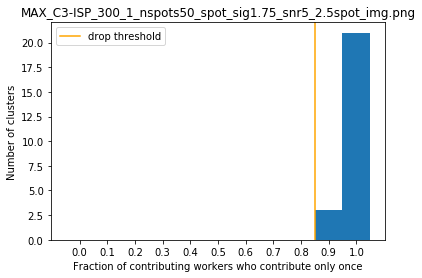

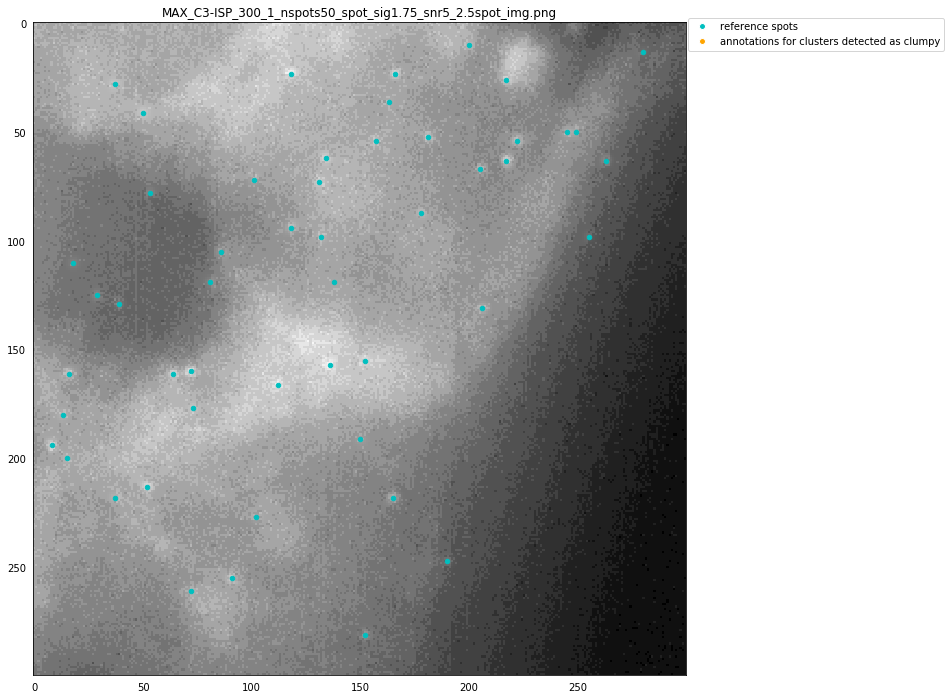

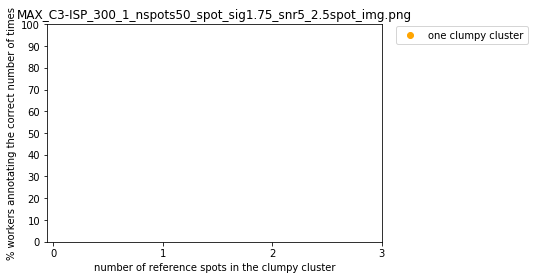

------------------- MAX_C3-ISP_300_1_nspots100_spot_sig1.75_snr5_2.5spot_img.png -------------------
counts:
[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  6. 42.]
---
prev_count 42.0
count 6.0
threshold_drop 0.85


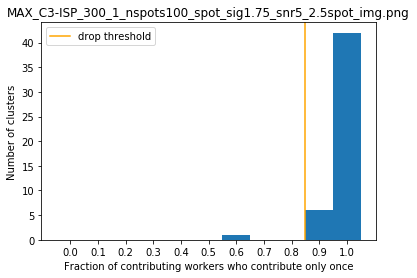

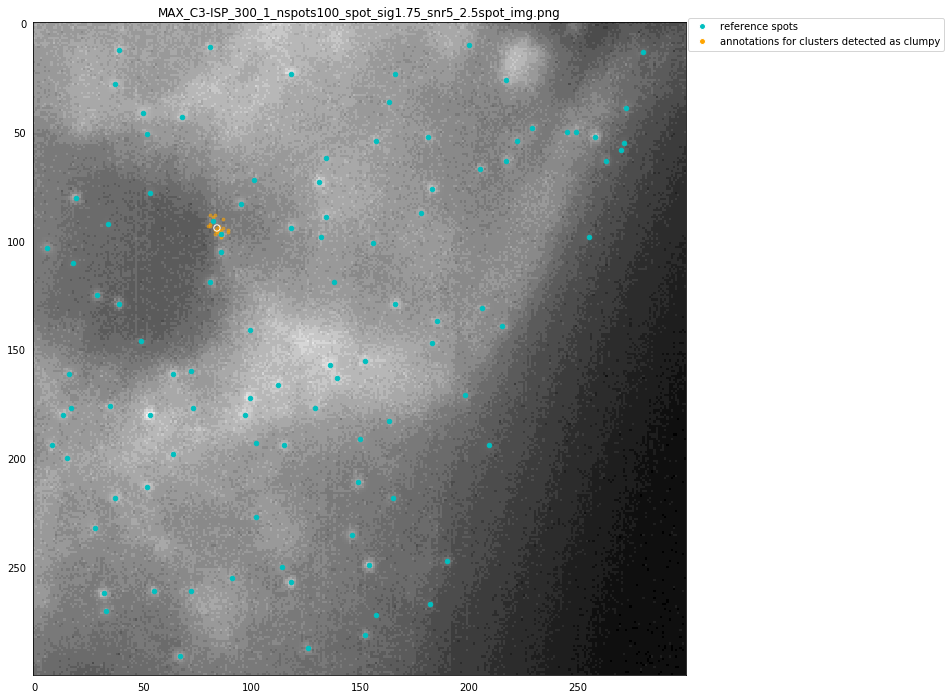

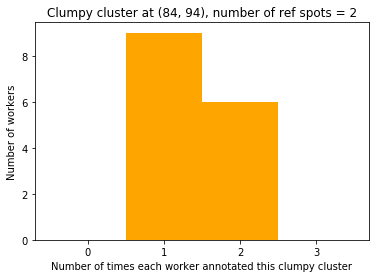

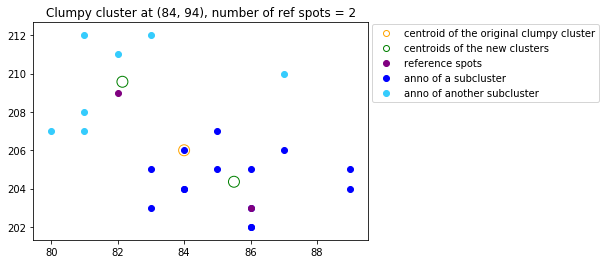

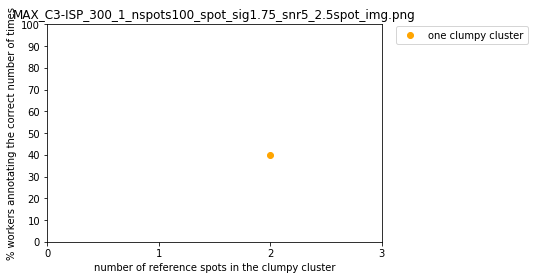

------------------- MAX_C3-ISP_300_1_nspots150_spot_sig1.75_snr5_2.5spot_img.png -------------------
counts:
[ 0.  0.  0.  0.  0.  0.  0.  0.  2. 27. 41.]
---
prev_count 27.0
count 2.0
threshold_drop 0.75


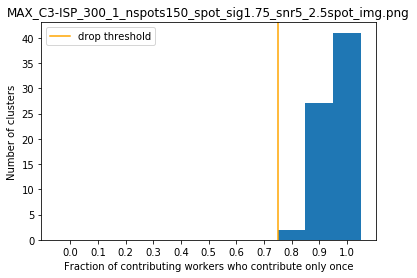

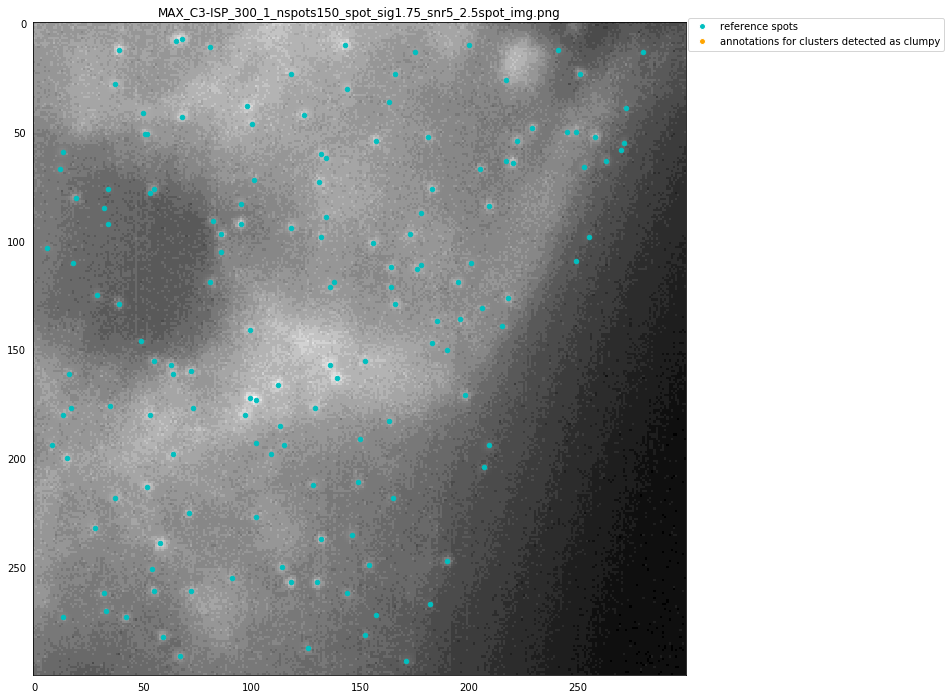

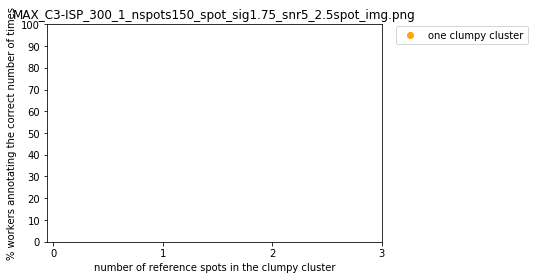

------------------- MAX_C3-ISP_300_1_nspots50_spot_sig1.75_snr10_2.5spot_img.png -------------------
counts:
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  7. 30.]
---
prev_count 30.0
count 7.0
threshold_drop 0.85


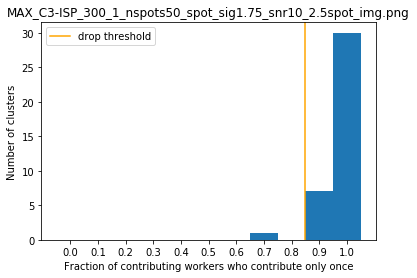

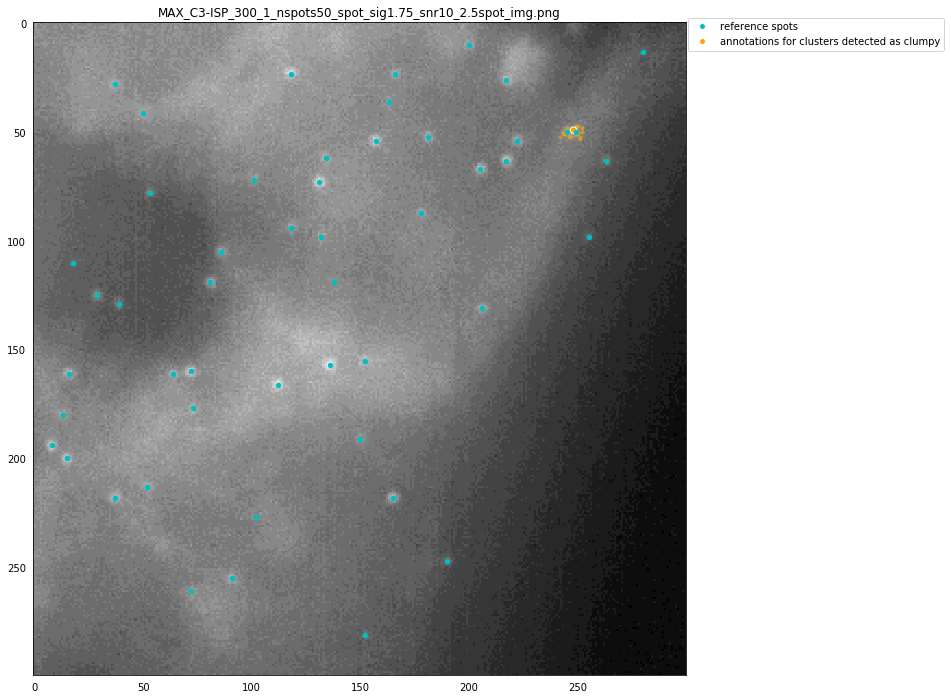

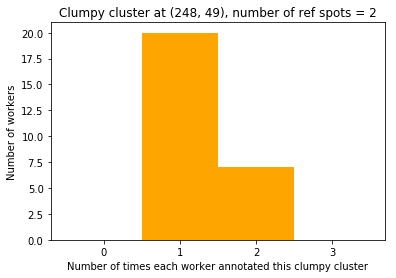

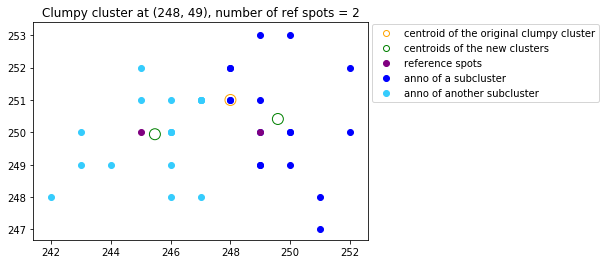

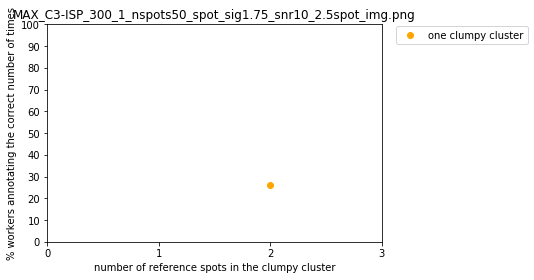

------------------- MAX_C3-ISP_300_1_nspots100_spot_sig1.75_snr10_2.5spot_img.png -------------------
counts:
[ 0.  0.  0.  0.  0.  0.  0.  0.  0. 10. 64.]
---
prev_count 64.0
count 10.0
threshold_drop 0.85


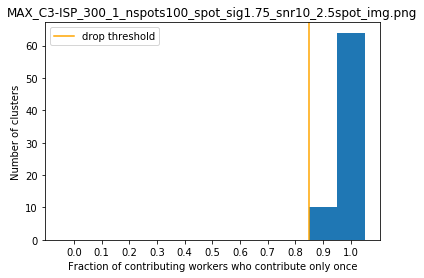

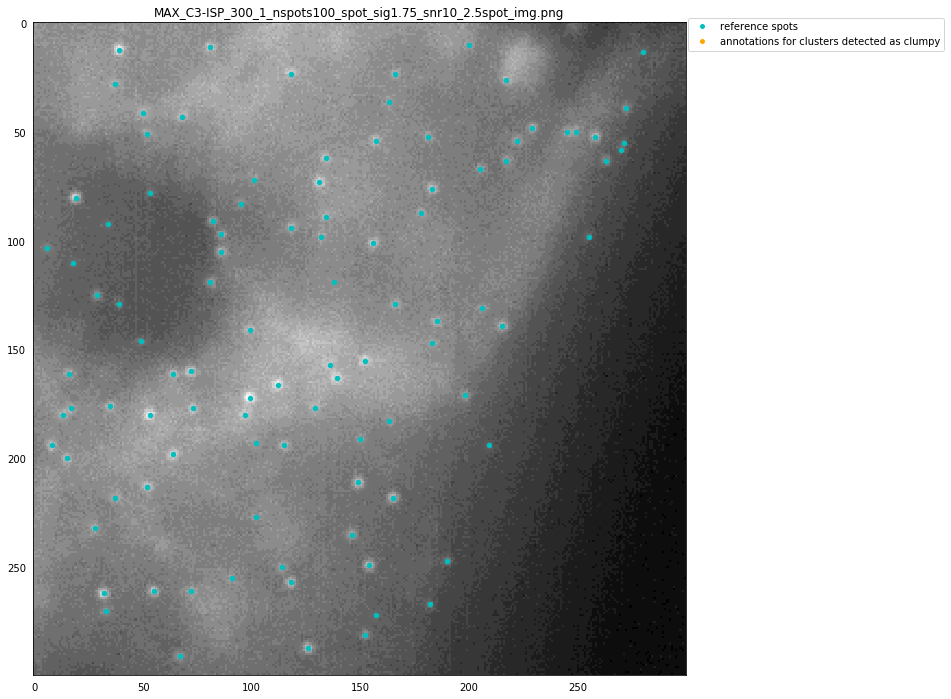

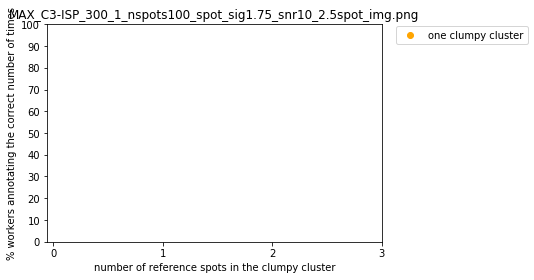

------------------- MAX_C3-ISP_300_1_nspots150_spot_sig1.75_snr10_2.5spot_img.png -------------------
counts:
[ 0.  0.  0.  0.  0.  0.  0.  0.  2. 11. 94.]
---
prev_count 94.0
count 11.0
threshold_drop 0.85
---
prev_count 11.0
count 2.0
threshold_drop 0.75


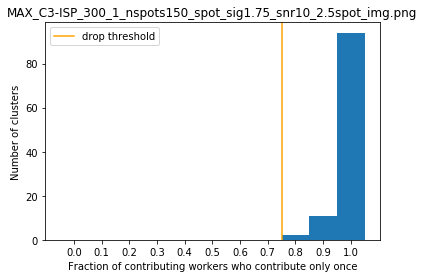

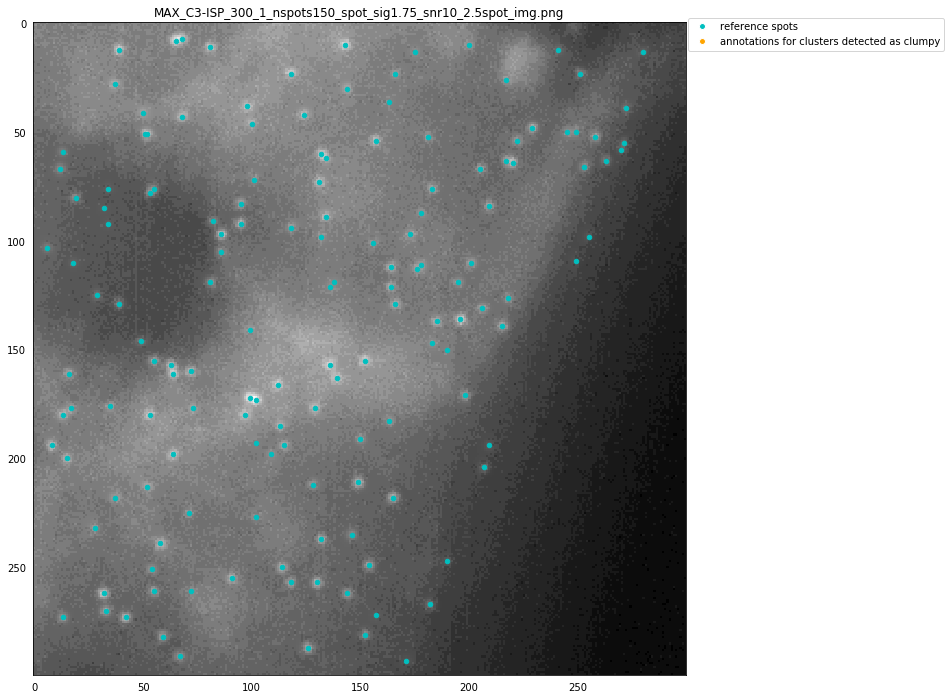

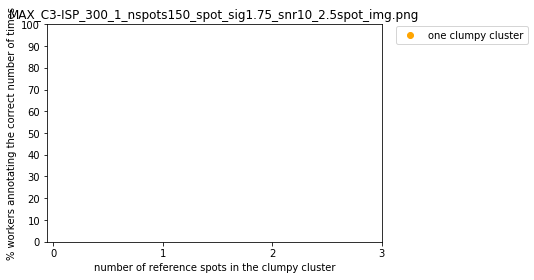

------------------- MAX_C3-ISP_300_1_nspots50_spot_sig1.75_snr20_2.5spot_img.png -------------------
counts:
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  2. 43.]
---
prev_count 43.0
count 2.0
threshold_drop 0.85


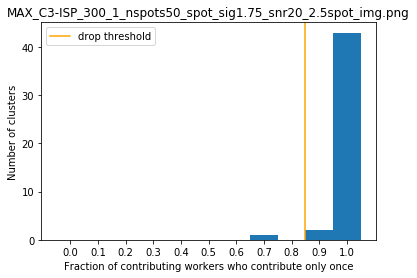

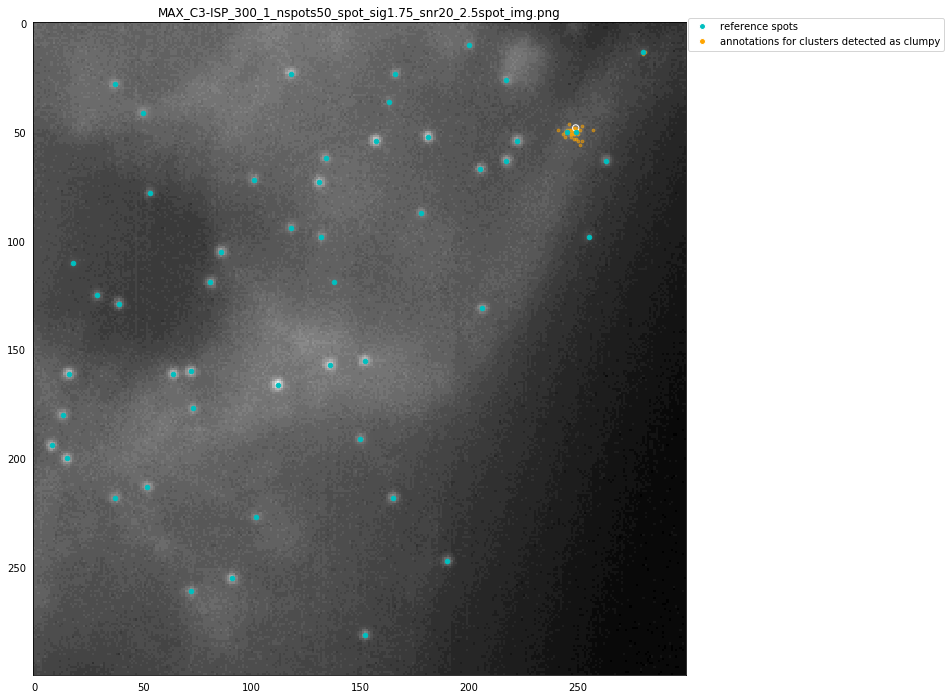

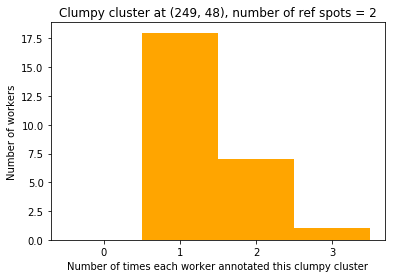

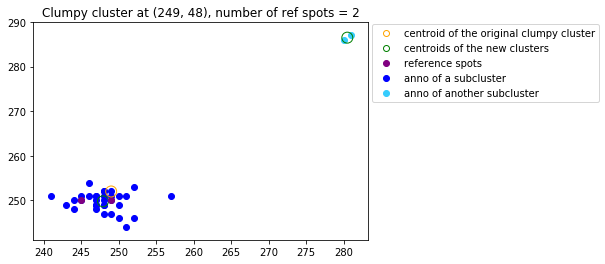

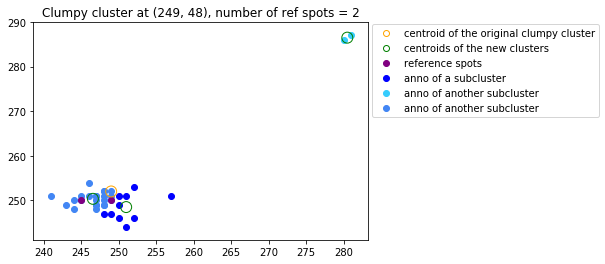

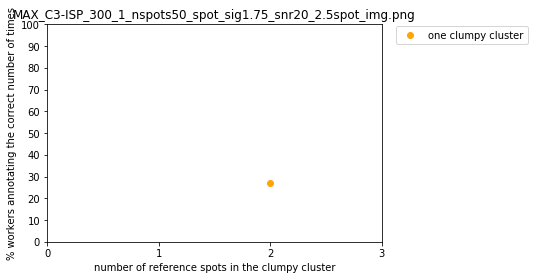

------------------- MAX_C3-ISP_300_1_nspots100_spot_sig1.75_snr20_2.5spot_img.png -------------------
counts:
[ 0.  0.  0.  0.  0.  0.  0.  0.  1. 14. 72.]
---
prev_count 72.0
count 14.0
threshold_drop 0.85
---
prev_count 14.0
count 1.0
threshold_drop 0.75


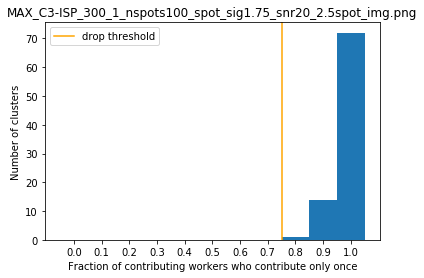

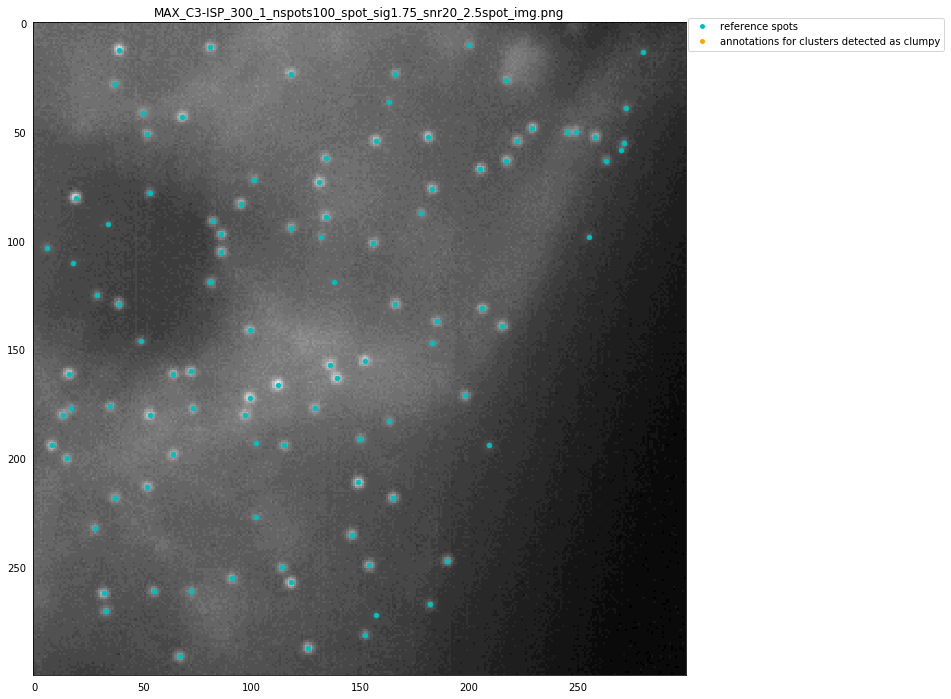

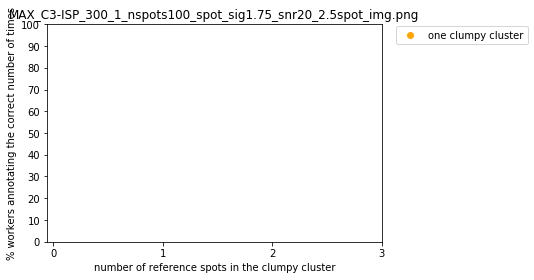

------------------- MAX_C3-ISP_300_1_nspots150_spot_sig1.75_snr20_2.5spot_img.png -------------------
counts:
[ 0.  0.  0.  0.  0.  0.  0.  1.  3. 23. 95.]
---
prev_count 95.0
count 23.0
threshold_drop 0.85
---
prev_count 23.0
count 3.0
threshold_drop 0.75


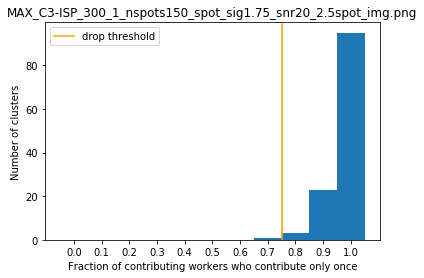

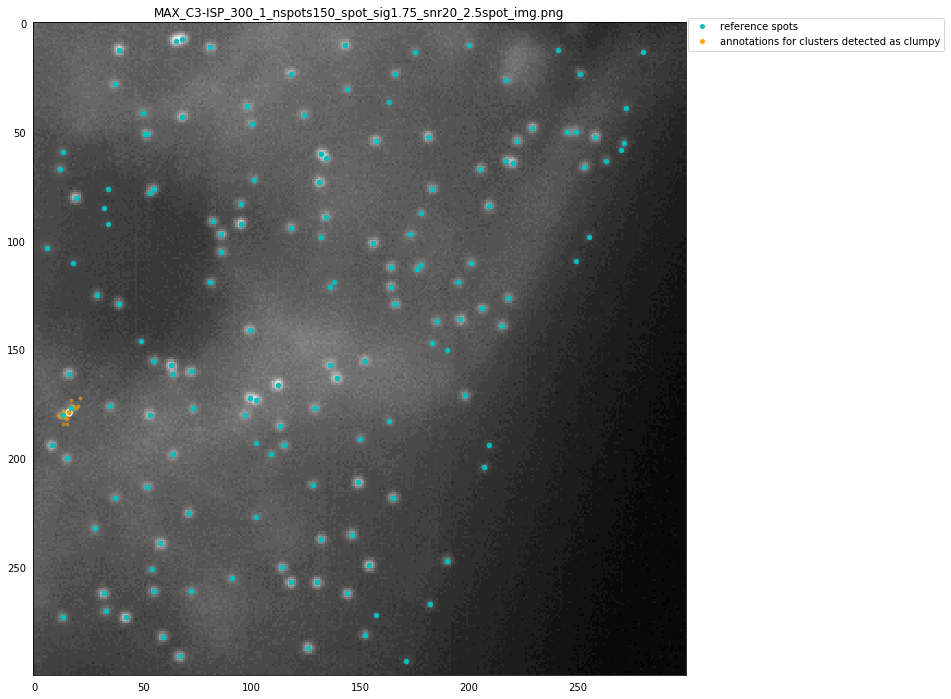

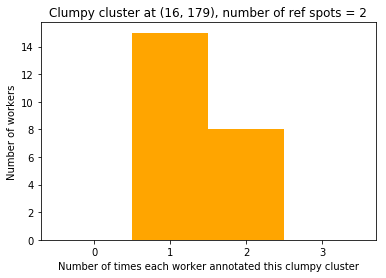

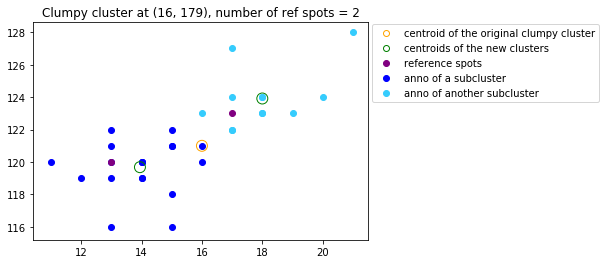

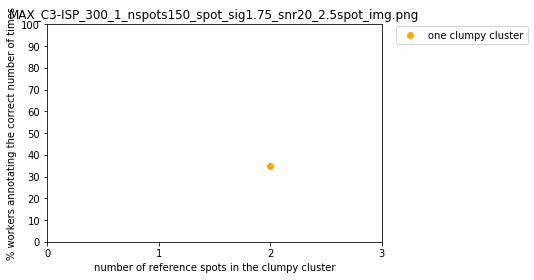

------------------- MAX_ISP_300_1_nspots50_spot_sig1.75_snr5_2.5spot_img.png -------------------
counts:
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  8. 23.]


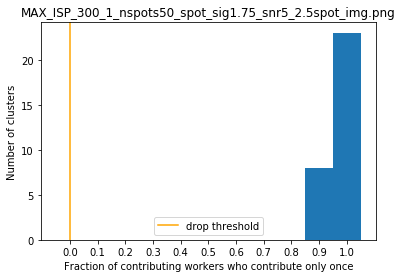

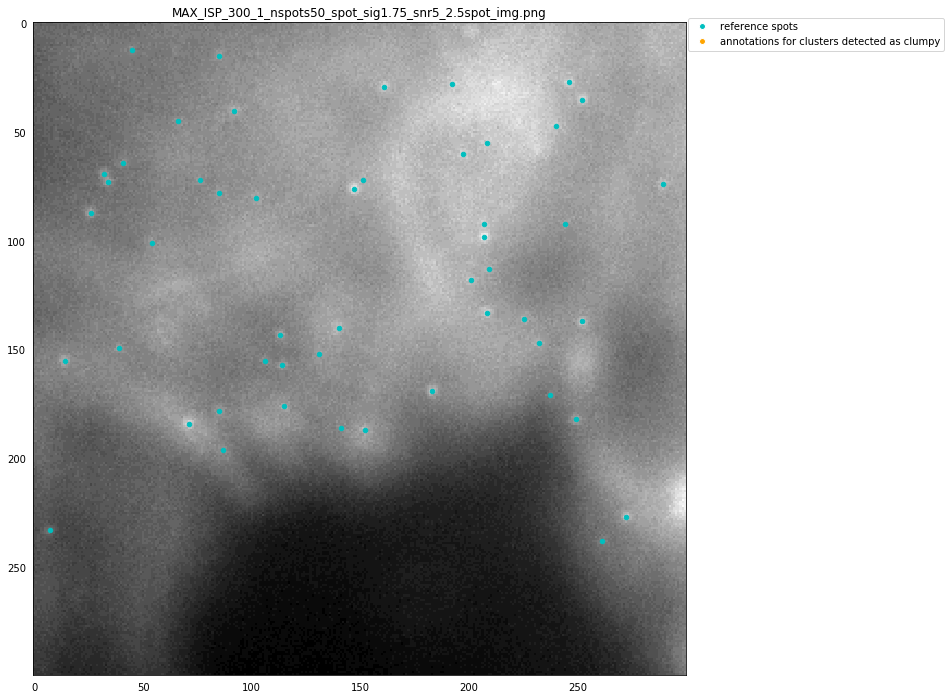

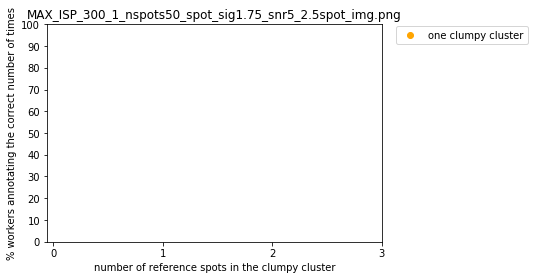

------------------- MAX_ISP_300_1_nspots100_spot_sig1.75_snr5_2.5spot_img.png -------------------
counts:
[ 0.  0.  0.  0.  0.  0.  0.  1.  1. 35. 20.]
---
prev_count 35.0
count 1.0
threshold_drop 0.75


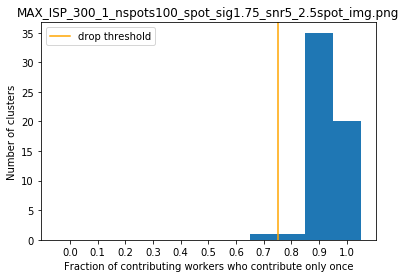

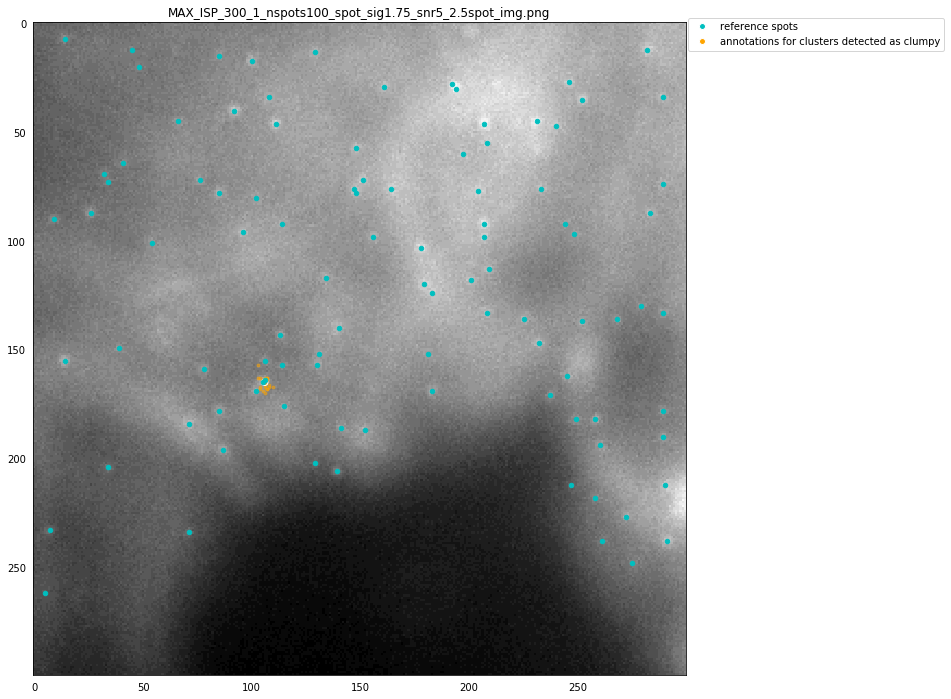

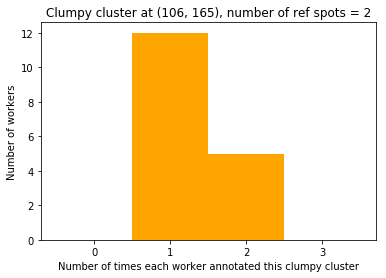

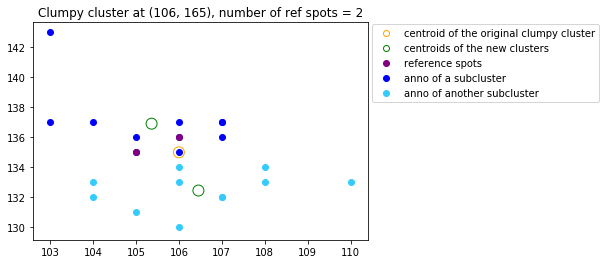

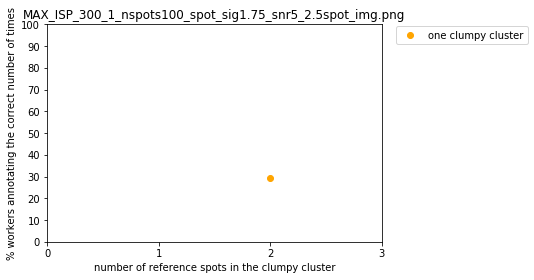

------------------- MAX_ISP_300_1_nspots150_spot_sig1.75_snr5_2.5spot_img.png -------------------
counts:
[ 0.  0.  0.  0.  0.  0.  1.  2.  9. 33. 38.]
---
prev_count 33.0
count 9.0
threshold_drop 0.75
---
prev_count 9.0
count 2.0
threshold_drop 0.65


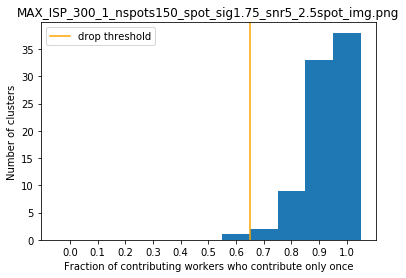

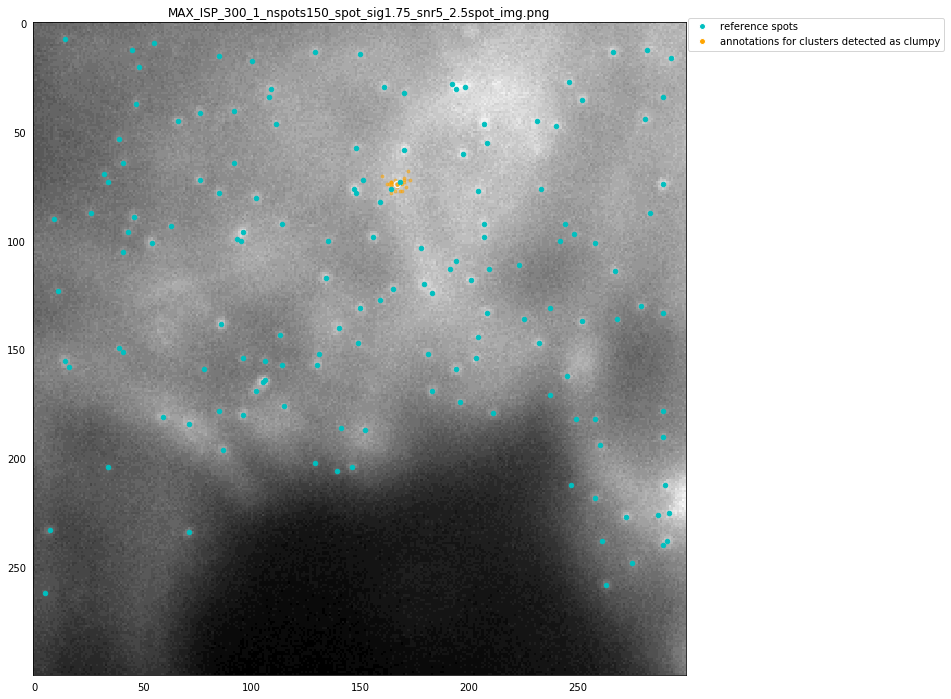

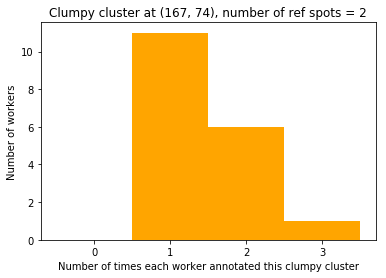

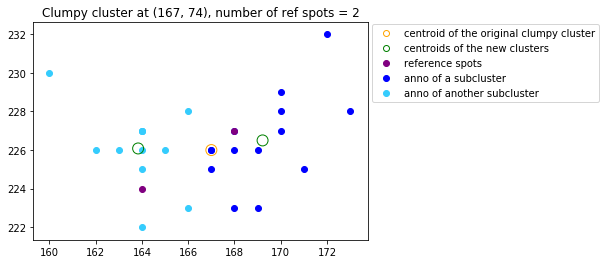

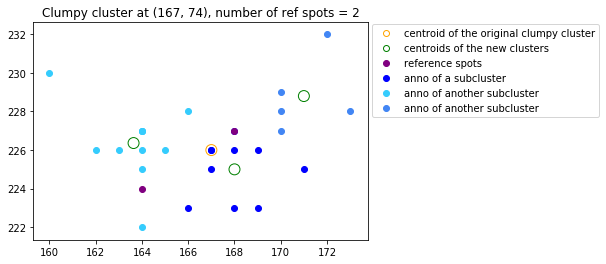

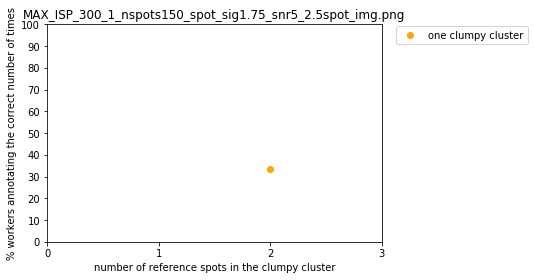

------------------- MAX_ISP_300_1_nspots50_spot_sig1.75_snr10_2.5spot_img.png -------------------
counts:
[ 0.  0.  0.  0.  0.  0.  0.  0.  1. 11. 35.]
---
prev_count 35.0
count 11.0
threshold_drop 0.85
---
prev_count 11.0
count 1.0
threshold_drop 0.75


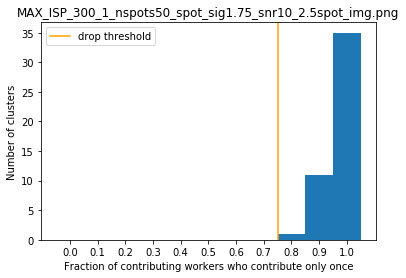

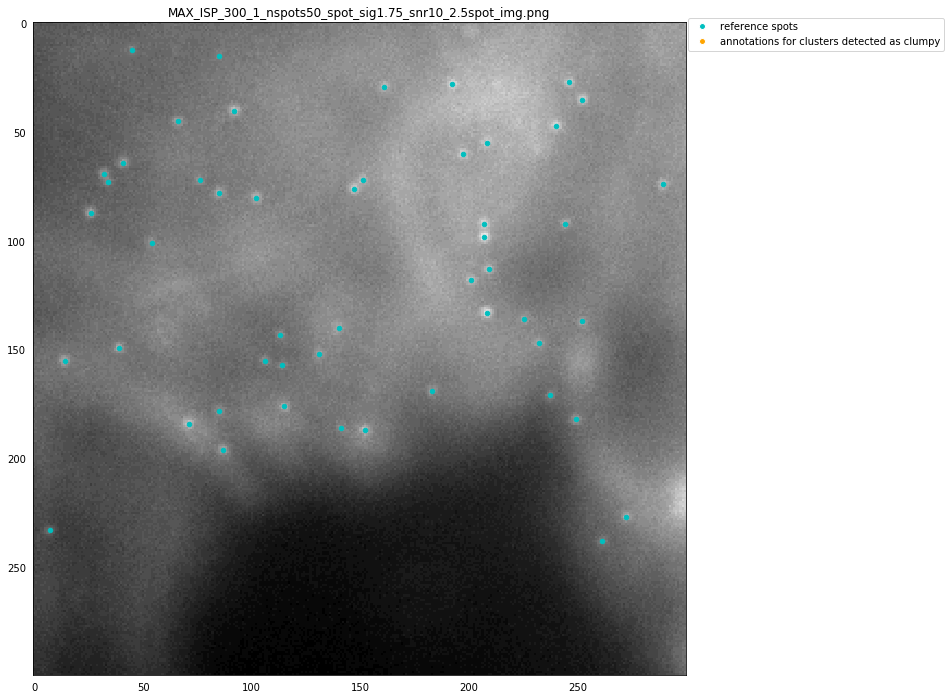

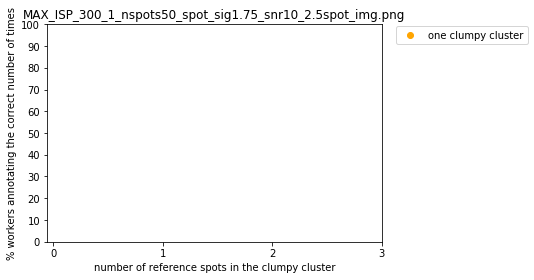

------------------- MAX_ISP_300_1_nspots100_spot_sig1.75_snr10_2.5spot_img.png -------------------
counts:
[ 0.  0.  0.  0.  0.  0.  1.  1.  0. 38. 38.]


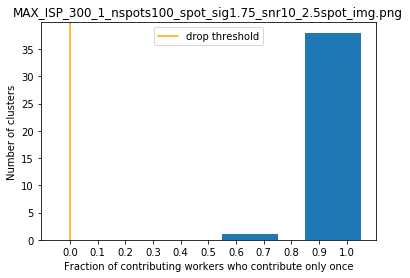

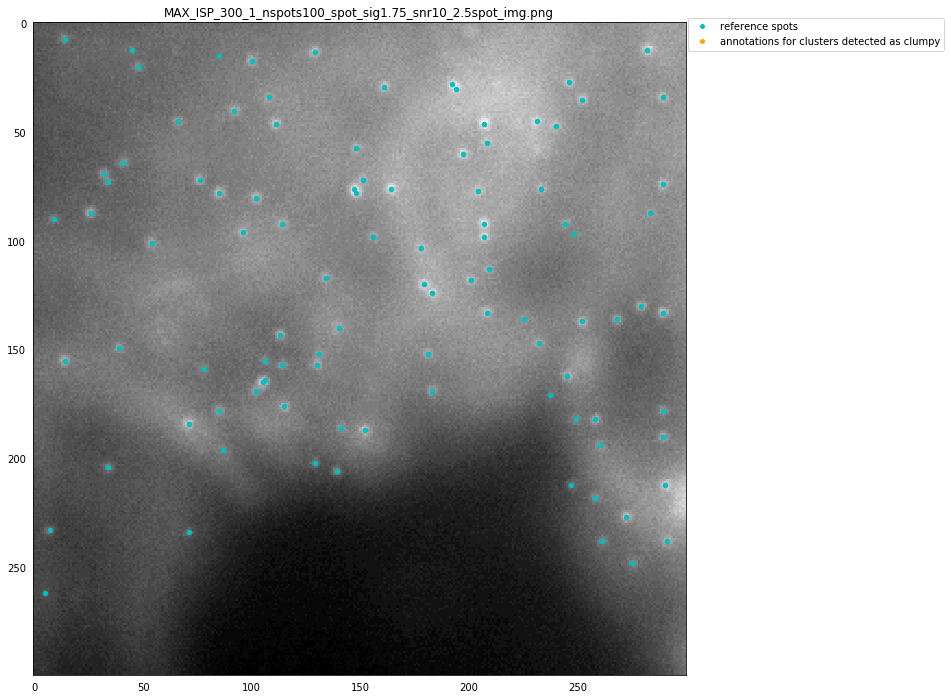

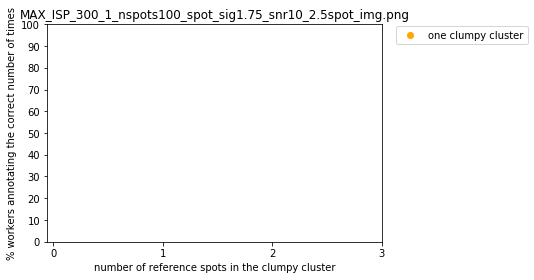

------------------- MAX_ISP_300_1_nspots150_spot_sig1.75_snr10_2.5spot_img.png -------------------
counts:
[ 0.  0.  0.  0.  0.  0.  1.  3. 10. 58. 53.]
---
prev_count 58.0
count 10.0
threshold_drop 0.75
---
prev_count 10.0
count 3.0
threshold_drop 0.65


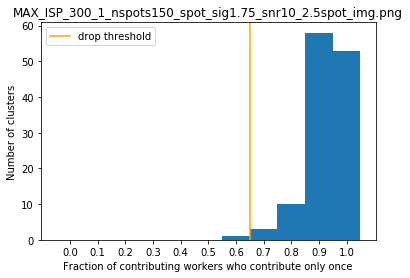

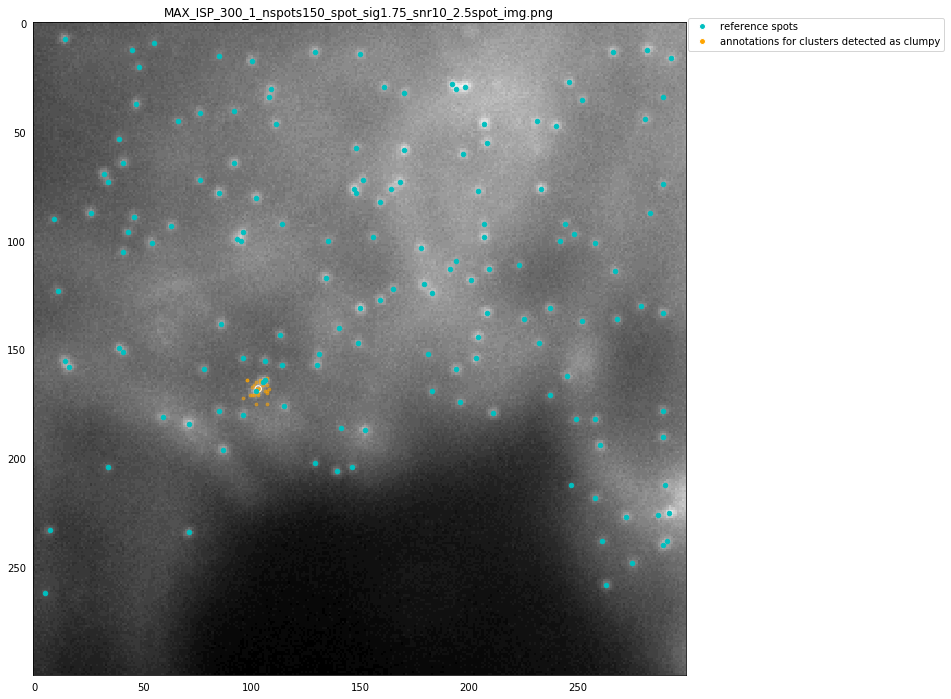

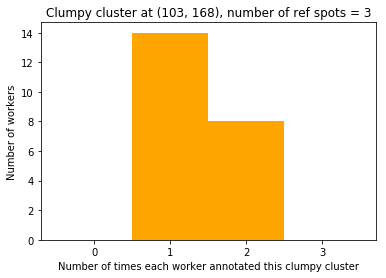

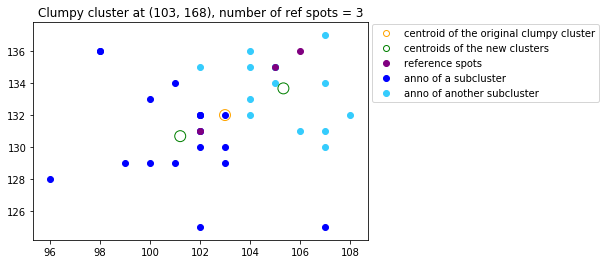

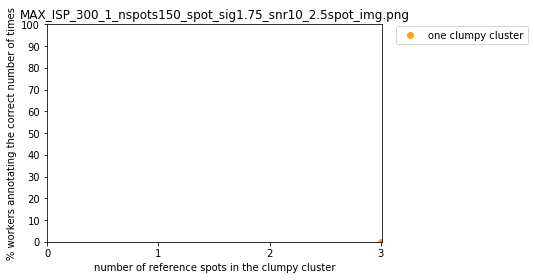

------------------- MAX_ISP_300_1_nspots50_spot_sig1.75_snr20_2.5spot_img.png -------------------
counts:
[ 0.  0.  0.  0.  0.  0.  0.  0.  1. 14. 34.]
---
prev_count 14.0
count 1.0
threshold_drop 0.75


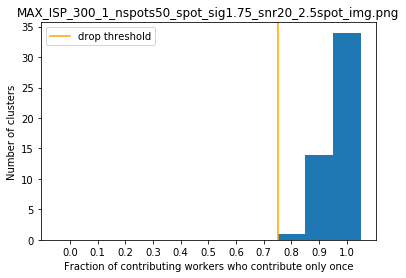

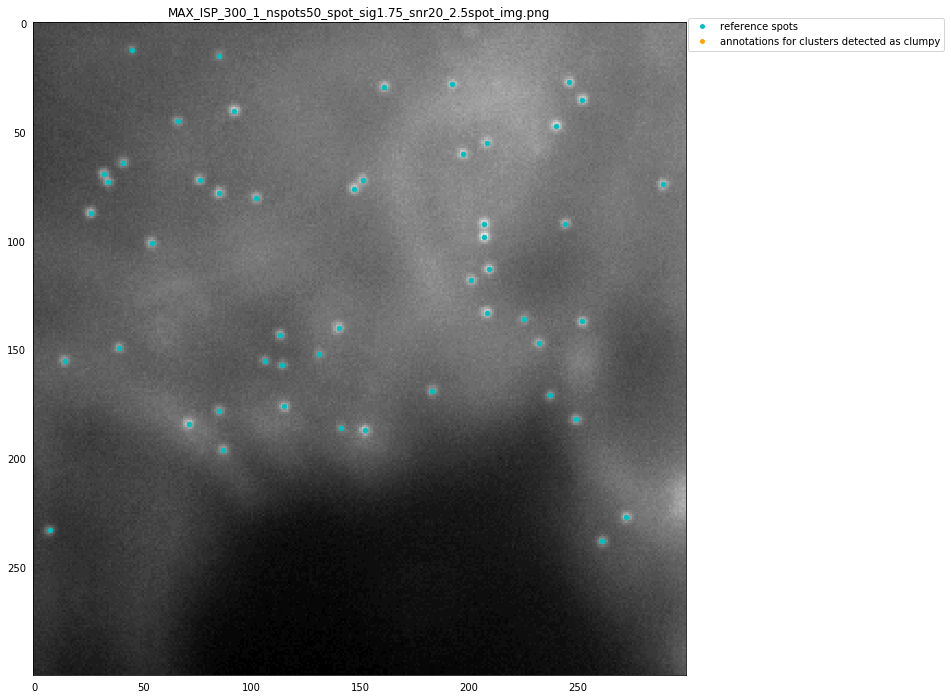

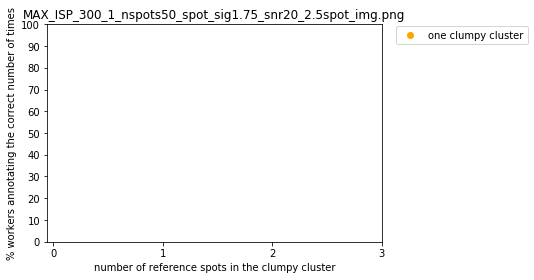

------------------- MAX_ISP_300_1_nspots100_spot_sig1.75_snr20_2.5spot_img.png -------------------
counts:
[ 0.  0.  0.  0.  0.  1.  1.  0.  1. 26. 63.]
---
prev_count 26.0
count 1.0
threshold_drop 0.75


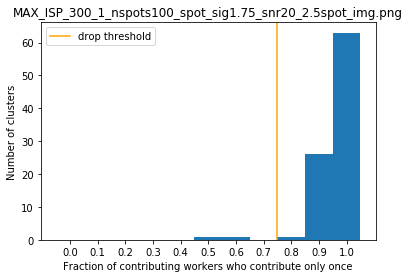

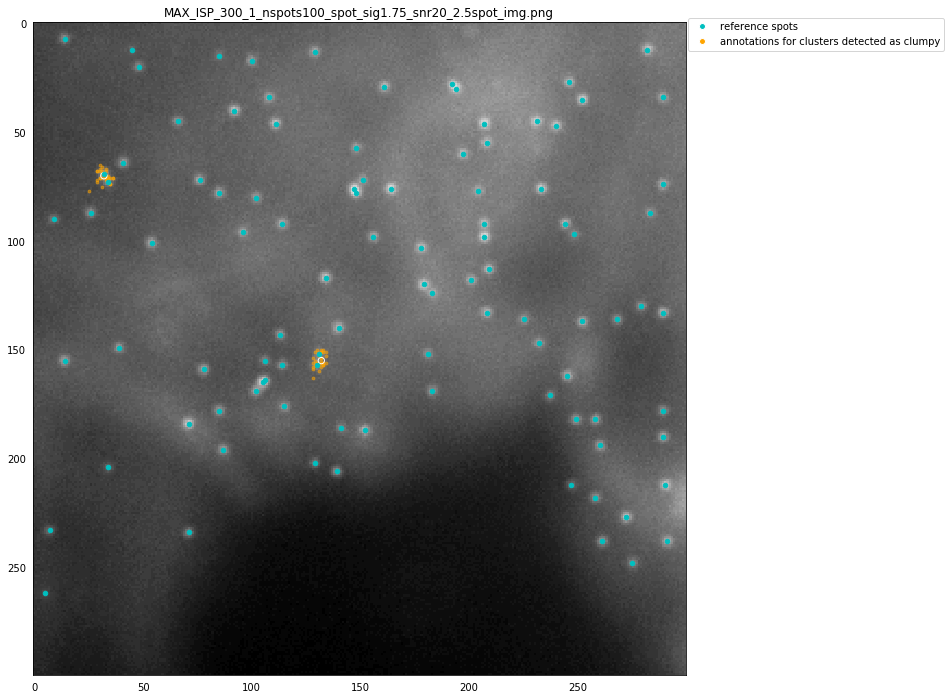

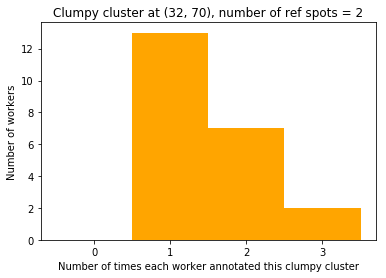

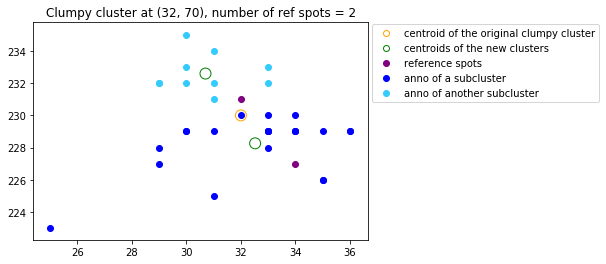

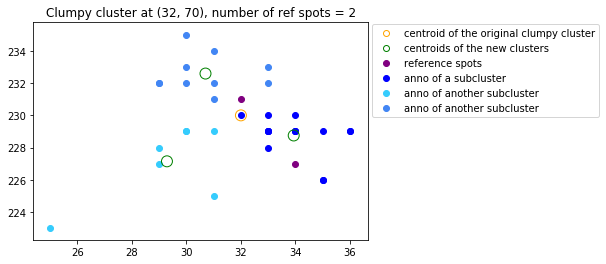

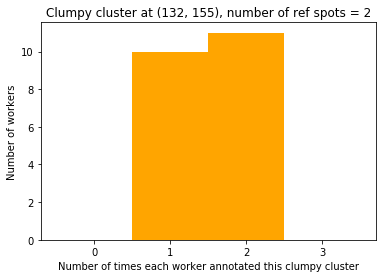

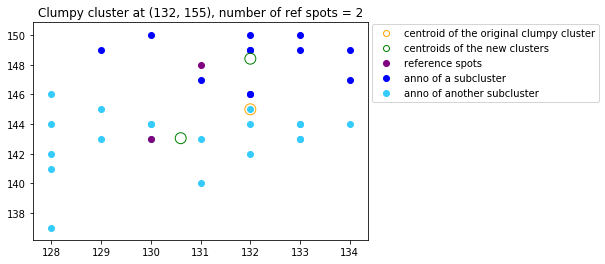

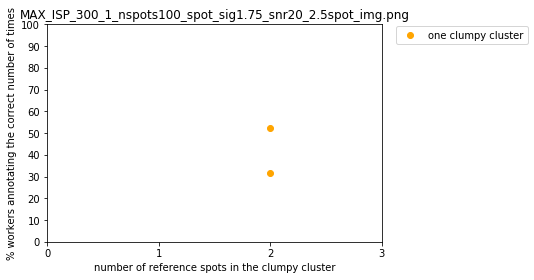

------------------- MAX_ISP_300_1_nspots150_spot_sig1.75_snr20_2.5spot_img.png -------------------
counts:
[ 0.  0.  0.  0.  0.  3.  0.  1.  6. 68. 59.]
---
prev_count 68.0
count 6.0
threshold_drop 0.75
---
prev_count 6.0
count 1.0
threshold_drop 0.65


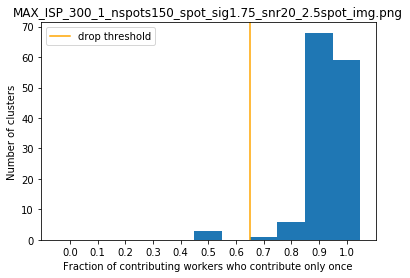

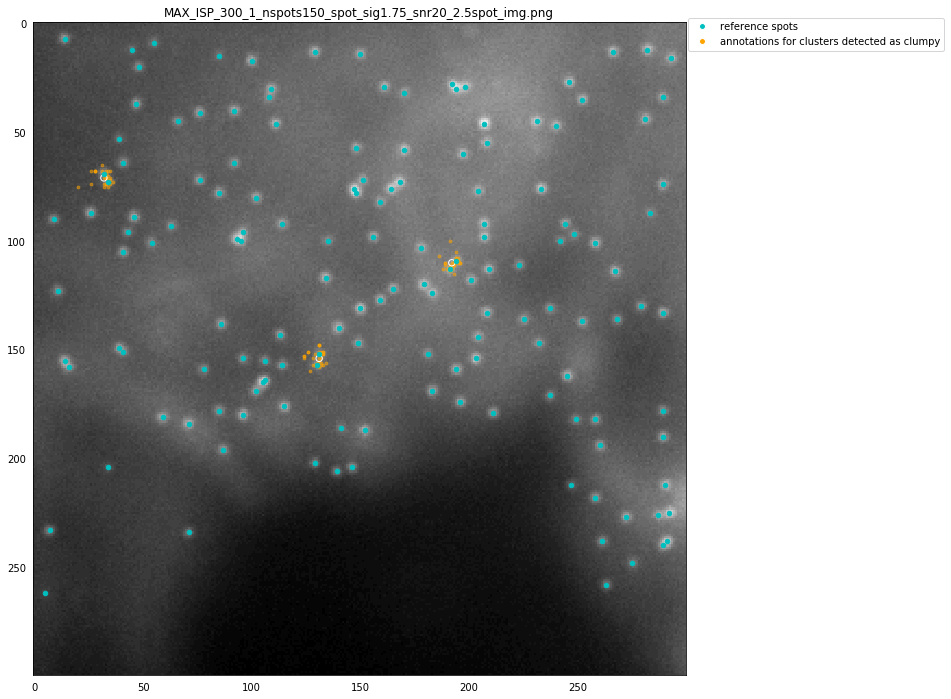

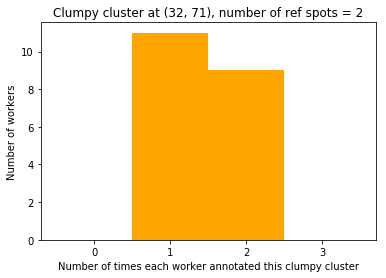

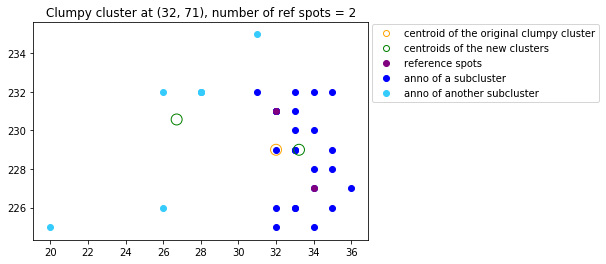

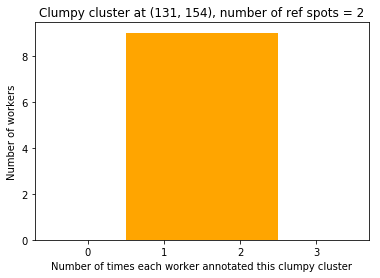

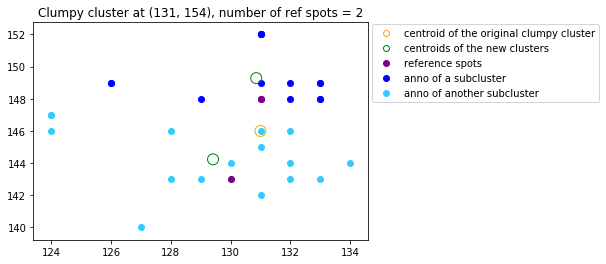

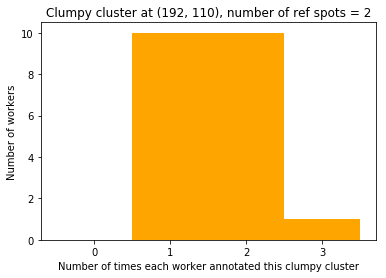

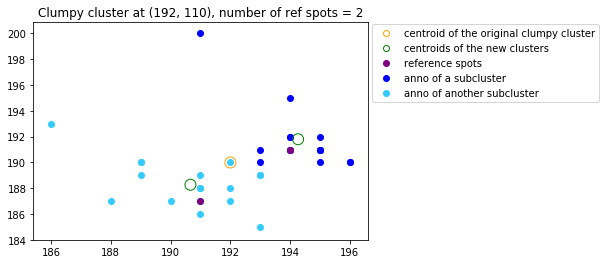

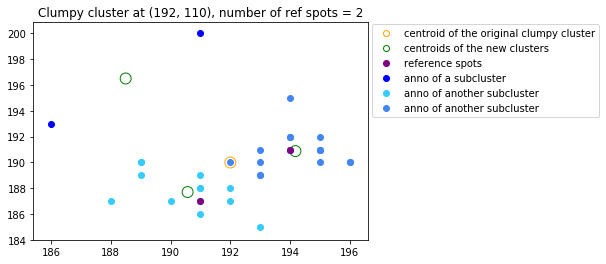

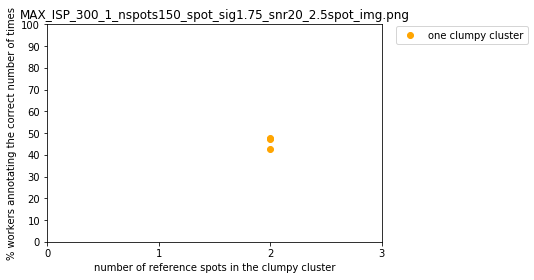

In [2]:
json_filename_list = ['SynthData_cells.json', 'SynthTests_tissue.json']
background_list = ['cells', 'tissue']
snr_mu_list = [5, 10, 20]
num_spots_list = [50, 100, 150]

for json_filename, background in zip(json_filename_list, background_list):
    for snr_mu in snr_mu_list:
        for num_spots in num_spots_list:
            if(background=='cells'):
                img_name = 'MAX_C3-ISP_300_1_nspots'+str(num_spots)+'_spot_sig1.75_snr'+str(snr_mu)+'_2.5'
            if(background=='tissue'):
                img_name = 'MAX_ISP_300_1_nspots'+str(num_spots)+'_spot_sig1.75_snr'+str(snr_mu)+'_2.5'
            img_filename = img_name+'spot_img.png'
            img_filepath = '/Users/jenny.vo-phamhi/Documents/FISH-annotation/Annotation/gen_20180719/spot_images/'+background+'/'+img_filename
            csv_filepath = '/Users/jenny.vo-phamhi/Documents/FISH-annotation/Annotation/gen_20180719/spot_data/'+background+'/'+img_name+'_coord_snr_list.csv'
            json_filepath = '/Users/jenny.vo-phamhi/Documents/FISH-annotation/Annotation/gen_20180719/'+json_filename

            print('------------------- ' + img_filename + ' -------------------')

            ba = QuantiusAnnotation(json_filepath)
            sa = SpotAnnotationAnalysis(ba)
            anno_all = ba.df()
            anno_one_image = ba.slice_by_image(anno_all, img_filename)
            ref_kdt = sa.csv_to_kdt(csv_filepath, img_height)
            ref_array = np.asarray(ref_kdt.data)

            # Get large clusters
            clusters = sa.get_clusters(anno_one_image, clustering_params)
            threshold = sa.get_cluster_size_threshold(clusters)
            threshold = math.ceil(threshold)
            small_clusters, large_clusters = sa.sort_clusters_by_size_input_threshold(clusters, threshold)

            single_fraction_list = []
            for i in range(len(large_clusters.index)):
                row = large_clusters.iloc[[i]]
                members = row.iloc[0]['members']
                workers = []
                x_coords = []
                y_coords = []
                for member in members:
                    x_coords.append(member[0])
                    y_coords.append(member[1])
                    workers.append(member[3])

                # Calculate replication of unique workers for each cluster
                unique_workers = np.unique(workers)
                num_instances_list = []
                for unique_worker in unique_workers:
                    num_instances_list.append(workers.count(unique_worker))
                singles = num_instances_list.count(1)
                single_fraction = singles/len(unique_workers)
                single_fraction_list.append(single_fraction)

            # plot single fraction histogram
            fig = plt.figure()
            (n, bins, patches) = plt.hist(single_fraction_list, bins = np.arange(0,1.2,0.1)-0.05)

            # calc drop-off threshold
            total_counts = n
            print('counts:')
            print(total_counts)
            total_counts_rev = list(reversed(total_counts))

            threshold_drop = 0
            prev_count = 0
            for i in range(len(total_counts_rev)):
                count = total_counts_rev[i]
                if (count != 0):
                    if((count < prev_count/3) and (count != 0) and (prev_count != 0)):
                        threshold_drop = 1-i*0.1-0.05
                        print('---')
                        print('prev_count ' + str(prev_count))
                        print('count ' + str(count))
                        print('threshold_drop ' + str(round(threshold_drop,2)))
                prev_count = count

            plt.xlabel('Fraction of contributing workers who contribute only once')
            plt.ylabel('Number of clusters')
            plt.xticks(np.arange(0,1.1, 0.1))
            drop_line = Line2D([0],[0], color='orange', label='drop threshold')
            plt.legend(handles=[drop_line])
            plt.axvline(x=threshold_drop, color='orange')
            plt.title(img_filename)
            plt.show()

            # sort clusters by predicted clumpiness
            clumpy_clusters, nonclumpy_clusters = sa.sort_clusters_by_clumpiness_input_threshold(large_clusters, threshold_drop)

            plot_title = img_filename
            sa.plot_clusters(clumpy_clusters, img_filename, img_filepath, img_height, csv_filepath, worker_marker_size, cluster_marker_size, show_correctness, correctness_threshold, show_possible_clumps, bigger_window_size, plot_title)
            spot_count_list = []
            correct_fraction = []
            for i in range(len(clumpy_clusters.index)):
                row = clumpy_clusters.iloc[[i]]
                members = row.iloc[0]['members']
                workers = []
                x_coords = []
                y_coords = []
                for member in members:
                    workers.append(member[3])
                    x_coords.append(member[0])
                    y_coords.append(member[1])
                unique_workers = np.unique(workers)

                num_instances_list = []
                for unique_worker in unique_workers:
                    num_instances_list.append(workers.count(unique_worker))

                # How many neighbors are in the area of this cluster?  
                centroid_coord = [row.iloc[0]['centroid_x'], row.iloc[0]['centroid_y']]
                dist, ind = ref_kdt.query([centroid_coord],k=3)
                spot_count = 0
                spots = []
                if(dist[0][0] <= 4):
                    for i in range(3):
                        index = ind[0][i]
                        spot = ref_array[index]
                        if ((spot[0] >= min(x_coords)) and (spot[0] <= max(x_coords)) and
                            (spot[1] >= min(y_coords)) and (spot[1] <= max(y_coords))):
                            spot_count += 1
                            spots.append(spot)

                correct_fraction.append((num_instances_list.count(spot_count)/len(unique_workers))*100)
                spot_count_list.append(spot_count)

                plt.hist(num_instances_list, bins = np.arange(0,5,1)-0.5, color='orange')
                plt.title('Clumpy cluster at (' + str(centroid_coord[0]) + ', ' + str(img_height-centroid_coord[1]) + '), number of ref spots = ' + str(spot_count))
                plt.xticks(np.arange(0,4,1))
                plt.xlabel('Number of times each worker annotated this clumpy cluster')
                plt.ylabel('Number of workers')
                plt.show()

                k_values = [2,3]
                for k_value in k_values:

                    # partition the clump
                    coords = np.stack((x_coords, y_coords), axis=-1)
                    km = KMeans(n_clusters=k_value).fit(coords)
                    centers = km.cluster_centers_
                    labels = km.labels_

                    # visualize the paritioning
                    plt.title('Clumpy cluster at (' + str(centroid_coord[0]) + ', ' + str(img_height-centroid_coord[1]) + '), number of ref spots = ' + str(spot_count))
                    # member annotations, colorized by membership in new clusters
                    for coord, label in zip(coords, labels):
                        if(label == 0):
                            color = 'blue'
                        elif(label == 1):
                            color = '#35ccfd'
                        elif(label == 2):
                            color = '#4286f4'
                        plt.scatter([coord[0]],[coord[1]],color=color)
                    # centroids of new clusters
                    for center in centers:
                        plt.scatter([center[0]],[center[1]],edgecolors='green',facecolors='None',s=120)
                    # reference spots
                    for spot in spots:
                        plt.scatter([spot[0]],[spot[1]],color='purple')
                    # centroid of the original clumpy cluster
                    plt.scatter([centroid_coord[0]],[centroid_coord[1]],edgecolors='orange',facecolors='None',s=120)

                    # legend elements
                    leg_elem_1 = Line2D([0], [0], marker='o', color = 'None', markeredgecolor='orange', markerfacecolor='None', label='centroid of the original clumpy cluster')
                    leg_elem_2 = Line2D([0], [0], marker='o', color = 'None', markeredgecolor='green', markerfacecolor='None', label='centroids of the new clusters')
                    leg_elem_3 = Line2D([0], [0], marker='o', color = 'None', markeredgecolor='purple', markerfacecolor='purple', label='reference spots')
                    leg_elem_4 = Line2D([0], [0], marker='o', color = 'None', markeredgecolor='blue', markerfacecolor='blue', label='anno of a subcluster')
                    leg_elem_5 = Line2D([0], [0], marker='o', color = 'None', markeredgecolor='#35ccfd', markerfacecolor='#35ccfd', label='anno of another subcluster')
                    if (k_value == 2):
                        handle_list = [leg_elem_1, leg_elem_2, leg_elem_3, leg_elem_4, leg_elem_5]
                    else:
                        leg_elem_6 = Line2D([0], [0], marker='o', color = 'None', markeredgecolor='#4286f4', markerfacecolor='#4286f4', label='anno of another subcluster')
                        handle_list = [leg_elem_1, leg_elem_2, leg_elem_3, leg_elem_4, leg_elem_5, leg_elem_6]
                    plt.legend(handles = handle_list, loc = 9, bbox_to_anchor = (1.35, 1.015))

                    plt.show()

                    if (num_instances_list.count(3) == 0):
                        break

            plt.scatter(spot_count_list, correct_fraction, c='orange')
            plt.legend(handles=[Line2D([0], [0], marker='o', color = 'None', markeredgecolor='orange', markerfacecolor='orange', label='one clumpy cluster')], bbox_to_anchor = (1.45, 1.015))
            plt.xlabel('number of reference spots in the clumpy cluster')
            plt.ylabel('% workers annotating the correct number of times')
            plt.xticks(np.arange(0,4,1))
            plt.yticks(np.arange(0,110,10))
            plt.title(img_filename)
            plt.show()
                